**Table of contents**<a id='toc0_'></a>    
1. [References](#toc1_)    
2. [Get the data](#toc2_)    
3. [Preprocess the data](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Setup](#toc0_)

- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [202]:
import numpy as np
import pandas as pd
import torch
print(torch.__version__)
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import yfinance as yf
import datetime as dt

from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from pprint import pprint

2.1.0+cpu


# 2. <a id='toc2_'></a>[Get the data](#toc0_)

In [4]:
# Override pandas datareader with yfinance
yf.pdr_override()

# Define the list of stock symbols
y_symbols = ['AAPL', 'GOOG', 'AMZN', 'TSLA', 'MSFT']

# Define the start and end dates for data retrieval
startdate = dt.datetime(2015, 1, 1)
enddate = dt.datetime(2020, 12, 31)

# Retrieve historical stock price data for the specified symbols and date range
df = yf.download(y_symbols, start=startdate, end=enddate)

# Stack the multi-level index to create a single-level index
df = df.stack(level=1)

# Reset the index to make 'Date' a regular column
df = df.reset_index()

# Rename the columns to match the desired structure
df.columns = ['Date', 'Stock', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

[*********************100%%**********************]  5 of 5 completed


In [5]:
# Save to a csv file
df.to_csv("Data/df_stocks.csv", index=False)

# 3. <a id='toc3_'></a>[Preprocess the data](#toc0_)

In [112]:
# Load the data
df = pd.read_csv("Data/df_stocks.csv")
# df

In [113]:
# Check for missing values
df.isnull().sum()

Date         0
Stock        0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [114]:
# Get counts for each stock
df["Stock"].value_counts()

Stock
AAPL    1510
AMZN    1510
GOOG    1510
MSFT    1510
TSLA    1510
Name: count, dtype: int64

In [115]:
# Calculate the difference in days
days_difference = (enddate - startdate).days
days_difference

2191

In [116]:
df_tsla = df[df["Stock"]=="TSLA"]
df_tsla.index = df_tsla["Date"]
df_tsla = df_tsla.copy()
df_tsla.drop(columns=["Date","Stock"], inplace=True)
df_tsla

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,14.620667,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05,14.006000,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06,14.085333,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07,14.063333,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08,14.041333,14.041333,14.253333,14.000667,14.187333,51637500
...,...,...,...,...,...,...
2020-12-23,215.326660,215.326660,217.166672,207.523331,210.733337,99519000
2020-12-24,220.589996,220.589996,222.029999,213.666672,214.330002,68596800
2020-12-28,221.229996,221.229996,227.133331,220.266663,224.836670,96835800


<Figure size 640x480 with 0 Axes>

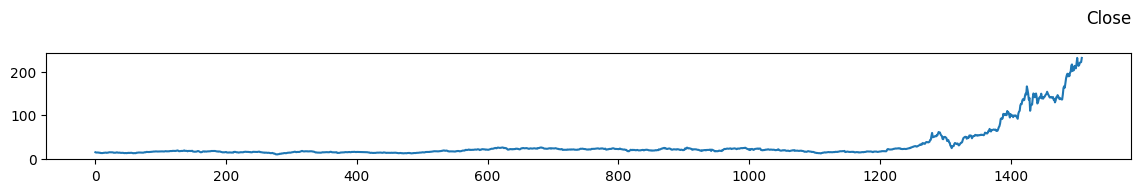

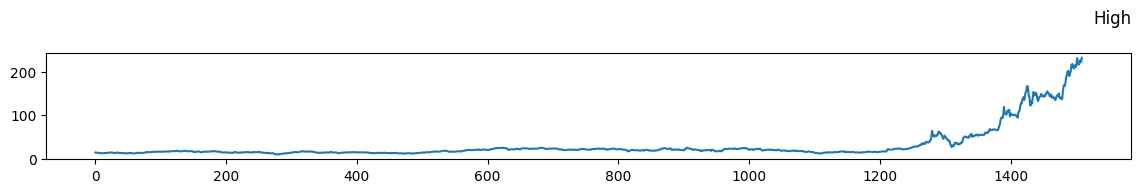

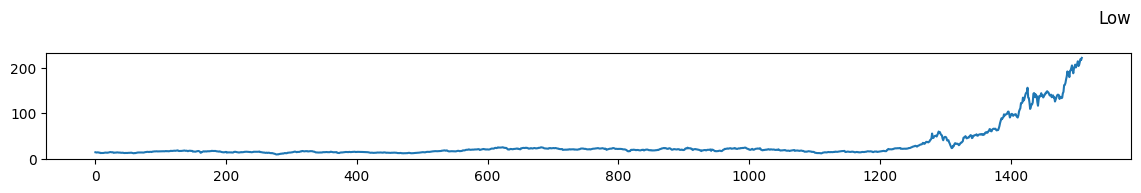

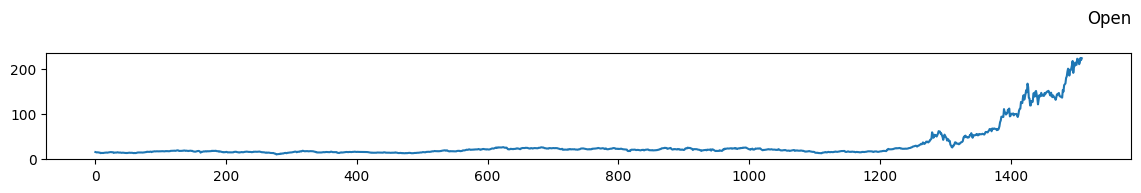

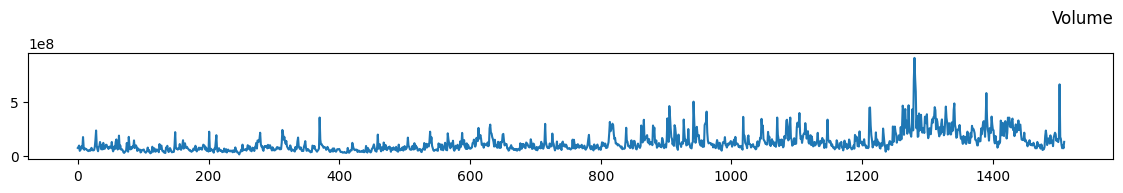

In [117]:
values = df_tsla.values

# specify columns to plot
groups = [1, 2, 3, 4, 5]
i = 1

# plot each column
plt.figure()
for group in groups:
    plt.figure(figsize=(14, 8))
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df_tsla.columns[group], y=1.2, loc='right')
    i += 1
# plt.show()

Epoch 1/20
9/9 - 2s - loss: 0.0177 - val_loss: 0.1861 - 2s/epoch - 169ms/step
Epoch 2/20
9/9 - 0s - loss: 0.0125 - val_loss: 0.1718 - 45ms/epoch - 5ms/step
Epoch 3/20
9/9 - 0s - loss: 0.0134 - val_loss: 0.1740 - 46ms/epoch - 5ms/step
Epoch 4/20
9/9 - 0s - loss: 0.0116 - val_loss: 0.1679 - 49ms/epoch - 5ms/step
Epoch 5/20
9/9 - 0s - loss: 0.0099 - val_loss: 0.1519 - 41ms/epoch - 5ms/step
Epoch 6/20
9/9 - 0s - loss: 0.0091 - val_loss: 0.1365 - 48ms/epoch - 5ms/step
Epoch 7/20
9/9 - 0s - loss: 0.0088 - val_loss: 0.1243 - 39ms/epoch - 4ms/step
Epoch 8/20
9/9 - 0s - loss: 0.0080 - val_loss: 0.1111 - 57ms/epoch - 6ms/step
Epoch 9/20
9/9 - 0s - loss: 0.0071 - val_loss: 0.0962 - 59ms/epoch - 7ms/step
Epoch 10/20
9/9 - 0s - loss: 0.0064 - val_loss: 0.0810 - 59ms/epoch - 7ms/step
Epoch 11/20
9/9 - 0s - loss: 0.0057 - val_loss: 0.0655 - 57ms/epoch - 6ms/step
Epoch 12/20
9/9 - 0s - loss: 0.0049 - val_loss: 0.0494 - 58ms/epoch - 6ms/step
Epoch 13/20
9/9 - 0s - loss: 0.0041 - val_loss: 0.0330 - 61ms

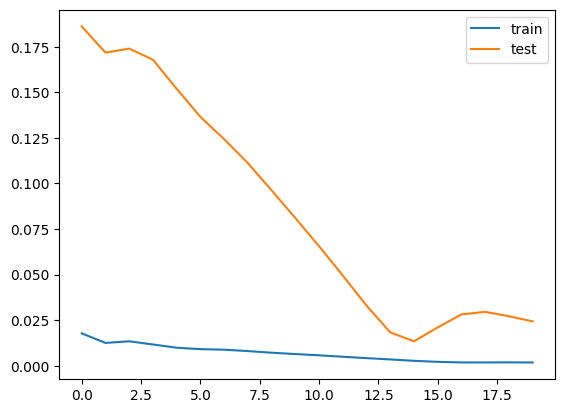

12/12 [==============================] - 0s 834us/step
Test RMSE: 9.613


In [118]:
from pandas import DataFrame
from pandas import concat

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = DataFrame(data)
    
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[7:], axis=1, inplace=True)
# print(reframed.head())


# split into train and test sets
values = reframed.values
n_train_hours = int(0.75 * reframed.shape[0])
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


# LSTM

In [252]:
# Functions

# Prepare the data
def prepare_data(df, choosen_stock, look_back, years_to_include):
    # Choose specific stock
    data = df[df["Stock"]==choosen_stock ]
    data = df[df["Date"].dt.year.isin(years_to_include)]

    # Feature selection and engineering
    # Consider only the 'Close' column
    data = data["Close"].values
    data = data.reshape(-1, 1)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    # Split data into training and testing sets
    train_size = int(len(data) * 0.8)
    train_data, test_data = data[0:train_size, :], data[train_size:len(data), :]
    
    # Create sequences for LSTM input
    def create_sequences(dataset, look_back=1):
        X, Y = [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back), 0])
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)
    
    train_X, train_Y = create_sequences(train_data, look_back)
    test_X, test_Y = create_sequences(test_data, look_back)
    
    # Convert data to PyTorch tensors
    train_X = torch.Tensor(train_X).view(-1, 1, look_back)
    train_Y = torch.Tensor(train_Y).view(-1, 1)
    test_X = torch.Tensor(test_X).view(-1, 1, look_back)
    test_Y = torch.Tensor(test_Y).view(-1, 1)
    
    return train_X, train_Y, test_X, test_Y


# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    
def train_evaluate_lstm(input_size, hidden_size, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, test_X, test_Y):
    # Initialize the model
    model = LSTMModel(input_size, hidden_size, num_layers, output_size)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    # Training the model
    train_losses = []
    for epoch in range(num_epochs):
        outputs = model(train_X)
        optimizer.zero_grad()
        loss = criterion(outputs, train_Y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        # if (epoch + 1) % 20 == 0 or (epoch + 1) % num_epochs == 0:
            # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    model.eval()
    train_predict = model(train_X)
    test_predict = model(test_X)

    # Inverse transform the predictions to the original scale
    train_predict = scaler.inverse_transform(train_predict.detach().numpy())
    train_Y = scaler.inverse_transform(train_Y.numpy())
    test_predict = scaler.inverse_transform(test_predict.detach().numpy())
    test_Y = scaler.inverse_transform(test_Y.numpy())

    # Evaluate the model using metrics like mean squared error (MSE)
    train_rmse = mean_squared_error(train_Y, train_predict, squared= False)
    test_rmse = mean_squared_error(test_Y, test_predict, squared= False)
    
    # Visualization of training loss
    plt.plot(train_losses)
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
    return model, loss, test_rmse

In [257]:
## Tuning

# Load the data
df = pd.read_csv("Data/df_stocks.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Hyperparameters
choosen_stock = "GOOG"  # [TSLA, GOOG, AAPL, MSFT, AMZN]
look_back_values = [5, 10, 15, 20]  # Adjust the look_back window values as needed
hidden_size_values = [32, 64, 128]  # Adjust the hidden_size values as needed
num_layers_values = [2, 3, 4]  # Adjust the num_layers values as needed
learning_rate_values = [0.005, 0.01, 0.02]  # Adjust the learning_rate values as needed
num_epochs = 100
years_to_include = [2018, 2019]

best_models = []
top_k = 5  # Get the top 5 performing models

# Hyperparameter tuning loop
for look_back in look_back_values:
    for hidden_size in hidden_size_values:
        for num_layers in num_layers_values:
            for learning_rate in learning_rate_values:
                # print(f"\nHyperparameters: look_back={look_back}, hidden_size={hidden_size}, num_layers={num_layers}, learning_rate={learning_rate}")
                train_X, train_Y, test_X, test_Y = prepare_data(df, choosen_stock, look_back, years_to_include)
                model, loss, rmse = train_evaluate_lstm(look_back, hidden_size, num_layers, 1, learning_rate, num_epochs, train_X, train_Y, test_X, test_Y)
                best_models.append({
                    "look_back": look_back,
                    "hidden_size": hidden_size,
                    "num_layers": num_layers,
                    "learning_rate": learning_rate,
                    "rmse": rmse,
                })
                
# Sort the models by RMSE in ascending order
best_models.sort(key=lambda x: x["rmse"])

# Print the top-k performing models
print(f"\nTop {top_k} Performing Models:")
pprint(best_models[:top_k])


Top 5 Performing Models:
[{'hidden_size': 64,
  'learning_rate': 0.02,
  'look_back': 5,
  'num_layers': 3,
  'rmse': 4.9649963},
 {'hidden_size': 32,
  'learning_rate': 0.02,
  'look_back': 15,
  'num_layers': 4,
  'rmse': 5.832683},
 {'hidden_size': 64,
  'learning_rate': 0.02,
  'look_back': 20,
  'num_layers': 3,
  'rmse': 5.933159},
 {'hidden_size': 128,
  'learning_rate': 0.02,
  'look_back': 5,
  'num_layers': 3,
  'rmse': 5.9525495},
 {'hidden_size': 64,
  'learning_rate': 0.02,
  'look_back': 10,
  'num_layers': 3,
  'rmse': 6.009134}]


In [256]:
## Standalone code

# Hyperparameters
choosen_stock = "GOOG" # [TSLA, GOOG, AAPL, MSFT, AMZN]
look_back = 5  # Adjust the look_back window as needed
input_size = look_back
hidden_size = 128
num_layers = 2
output_size = 1
learning_rate = 0.01
num_epochs = 100
years_to_include = [2019]

# Prepare the data
# print("Data Preparation")
train_X, train_Y, test_X, test_Y = prepare_data(df, choosen_stock, look_back, years_to_include)

# Train the model
# print("\nTraining")
model, loss, test_rmse = train_evaluate_lstm(input_size, hidden_size, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, test_X, test_Y)

print(model)
print(test_rmse)

LSTMModel(
  (lstm): LSTM(5, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
8.229324
